### Here we will estimate the minimum SN rate observable

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
import swordfish as sf
from random import *
from tqdm import tqdm
import scipy.interpolate as interpolate
from scipy.integrate import quad
import paleopy as paleopy
from WIMpy import DMUtils as DMU
from scipy.special import gamma
from SN import *

rc('text', usetex=True)
rc('font',**{'family':'sans-serif','sans-serif':['cmr']})
rc('font',**{'family':'serif','serif':['cmr']})
rc('font', size=16)

In [3]:
Epso = paleopy.Mineral("Epsomite")

def MakeSF(mineral, sigma, exposure):
    systematics = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1e-2, 1e-2]
    dRdx_BG = paleopy.GetBackground(mineral, sigma)
    SF = sf.Swordfish(dRdx_BG, T=systematics, E=np.ones_like(dRdx_BG[0])*exposure)
    return SF, dRdx_BG

print("Catching some Swordfish with Epsomite...")
SF_Epso_15nm, Epso_bkg = MakeSF(Epso, 15.0, 100.)
print("...done.")

Catching some Swordfish with Epsomite...
 DMutils.py: Loading neutrino flux for the first time...
Loading neutrino fluxes for...
    DSNB
    atm
    hep
    8B
    15O
    17F
    pep
    13N
    pp
    7Be-384
    7Be-861
...done.


/Users/bradkav/anaconda3/lib/python3.6/site-packages/paleopy/paleopy.py:355: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  N_events_ind[i] = quad(integ, x1, x2, epsrel=1e-4)[0] + 1e-30
/Users/bradkav/anaconda3/lib/python3.6/site-packages/paleopy/paleopy.py:355: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  N_events_ind[i] = quad(integ, x1, x2, epsrel=1e-4)[0] + 1e-30


...done.


Mineral name: Epsomite
    N_nuclei: 4
    Molar mass: 246.3  g/mol
    nucleus 	*	 abun.  *	 (N_p, N_n)
 **************************************************
    Mg		*	0.09866017052375152	*	(12.0, 12.3)
    S		*	0.12992285830288267	*	(16.0, 16.0)
    O		*	0.7145757206658546	*	(8.0, 8.0)
    H		*	0.05684125050751116	*	(1.0, 0.0)
Plotting SRIM data for Epsomite:


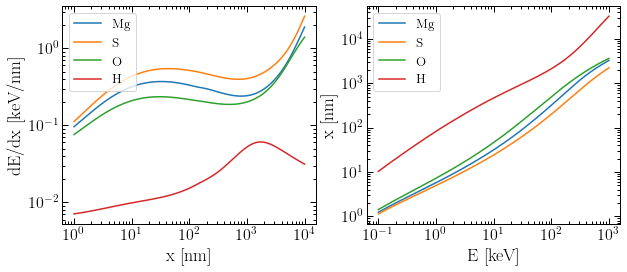

100%|██████████| 100000/100000 [01:18<00:00, 1269.39it/s]
/Users/bradkav/Code/SN-paleology/Notebooks/SN.py:76: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  dist_bin = np.histogram(R, bins=b_edge, normed=True)


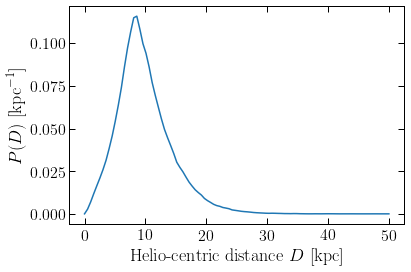

/Users/bradkav/Code/SN-paleology/Notebooks/SN.py:101: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  dNdE_gal = dndE*quad(dist_weight, 0., 30)[0]/(3.086e+21**2) # Convert kpc^-2 to cm^-2
  0%|          | 0/69 [00:00<?, ?it/s]/Users/bradkav/Code/SN-paleology/Notebooks/SN.py:144: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  dRdx_binned[i] = quad(intge, x1, x2)[0] + 1e-30
/Users/bradkav/Code/SN-paleology/Notebooks/SN.py:144: IntegrationWarning: The maximum number 

In [4]:
dRdx_binned = calcdRdx()

In [5]:
significance = np.logspace(-8,-1,50)
R = np.zeros_like(significance)

for i, s in enumerate(significance):
    R[i] = SF_Epso_15nm.discoveryreach(dRdx_binned,s)

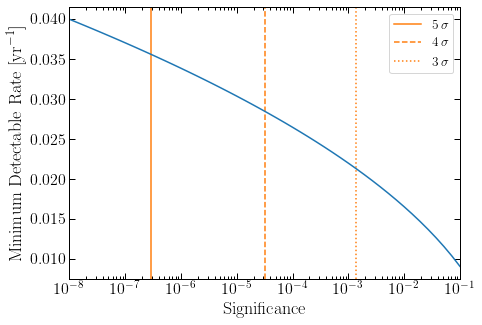

In [6]:
A0 = 1 # s^-1
A0 *= 1*365*1e6*86400 # Myr^-1
R_peryer = R*A0/1e6 # yr^-1

plt.figure(figsize=(7,5))

plt.axvline(x=2.87e-7, color='C1', label=r'$5 \,\sigma$')
plt.axvline(x=3.167e-05, color='C1', linestyle='--', label=r'$4 \,\sigma$')
plt.axvline(x=0.00135, color='C1', linestyle=':', label=r'$3 \,\sigma$')
plt.semilogx(significance, R_peryer)
plt.xlim(1e-8,1e-1)
plt.xlabel(r'Significance')
plt.ylabel(r'Minimum Detectable Rate [$\textrm{yr}^{-1}$]')
plt.legend()
# plt.savefig('../plots/R_min_vs_sig.pdf', bbox_inches='tight')
plt.show()

------------------------

## Detectable R_SN as a function of t_age and C_238

In [7]:
load_from_file = True

In [8]:
#t_age in Gyr
#Default significance is 3-sigma
def CalcDetectableR(t_age, C_238, miner="Epsomite", sigma=15.0, significance=0.00135):
    mineral = paleopy.Mineral(miner)
    mineral.U_frac = C_238
    
    exposure = 0.1*(t_age*1e3) #100g x t_age (exposure should be in kg Myr, t_age is in Gyr)
    
    systematics = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1e-2, 1e-2]
    
    dRdx_BG = paleopy.GetBackground(mineral, sigma)
    SF = sf.Swordfish(dRdx_BG, T=systematics, E=np.ones_like(dRdx_BG[0])*exposure)
    
    #Normalisation of SN rate in signal calculation
    #is fixed to 1/s.
    signal = calc_signal(mineral)
    Rate_per_second = SF.discoveryreach(signal,significance)
    Rate_per_Myr = Rate_per_second*1*365*86400
    return Rate_per_Myr

** As a function of t_age **

In [9]:
load_from_file = True

if (load_from_file):
    t_age_list, R_det_age_Halite, R_det_age_Epsomite, R_det_age_Nchwaningite, R_det_age_Olivine = np.loadtxt("../data/results/R_det_vs_age.txt", unpack = True)
    R_detect_age = {}
    R_detect_age["Halite"] = R_det_age_Halite
    R_detect_age["Epsomite"] = R_det_age_Epsomite
    R_detect_age["Nchwaningite"] = R_det_age_Nchwaningite
    R_detect_age["Olivine"] = R_det_age_Olivine

else:
    minerals = ["Halite","Epsomite","Nchwaningite", "Olivine"]
    C_list = [1e-11, 1e-11, 1e-10, 1e-10]
    R_detect_age = {}

    for mine, C in zip(minerals, C_list):
        N_t = 30
        t_age_list = np.linspace(0.1, 1.0, N_t)
        R_det_age = 0.0*t_age_list

        for i in tqdm(range(N_t)):
            R_det_age[i] = CalcDetectableR(t_age_list[i], C_238=C, miner=mine)

        R_detect_age[mine] = R_det_age
        
    headertxt = "Detectable R_SN as a function of mineral age (100g, 15nm, C_238 = 1e-11)"
    headertxt += "\nColumns: t_age [Gyr], R_SN (Olivine) [yr^-1], R_SN (Halite) [yr^-1], R_SN (Epsomite) [yr^-1], R_SN (Nchwaningite) [yr^-1]"

    np.savetxt("../data/results/R_det_vs_age.txt", list(zip(t_age_list, R_detect_age[minerals[0]], R_detect_age[minerals[1]],
                                                            R_detect_age[minerals[2]], R_detect_age[minerals[3]])), header=headertxt)
    

  0%|          | 0/30 [00:00<?, ?it/s]/Users/bradkav/anaconda3/lib/python3.6/site-packages/paleopy/paleopy.py:355: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  N_events_ind[i] = quad(integ, x1, x2, epsrel=1e-4)[0] + 1e-30
/Users/bradkav/Code/SN-paleology/Notebooks/SN.py:101: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  

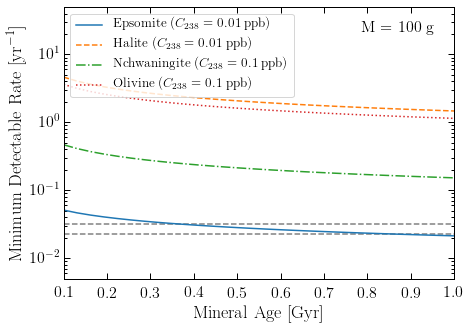

In [11]:
from itertools import cycle

plt.figure(figsize=(7,5))

plt.axhline(2.3e-2, linestyle='--', color='grey')
plt.axhline(3.2e-2, linestyle='--', color='grey')

minerals = ["Epsomite","Halite","Nchwaningite", "Olivine"]
labels =  ["Epsomite ($C_{238} = 0.01$ ppb)","Halite ($C_{238} = 0.01$ ppb)","Nchwaningite ($C_{238} = 0.1$ ppb)", "Olivine ($C_{238} = 0.1$ ppb)"]
lines = ["-","--","-.",":"]
linecycler = cycle(lines)

for mine,lab in zip(minerals, labels):
    plt.semilogy(t_age_list, R_detect_age[mine], label=lab, linestyle=next(linecycler))

plt.xlabel(r'Mineral Age [$\textrm{Gyr}$]')
plt.ylabel(r'Minimum Detectable Rate [$\textrm{yr}^{-1}$]')
#plt.legend()

plt.text(0.95, 0.95, "M = 100 g" ,
            va='top',ha='right', transform=plt.gca().transAxes)

plt.legend(loc=2)
#----------
plt.xlim(0.1,1.)
plt.xticks(np.linspace(0.1, 1.0, 10))

plt.ylim(5e-3, 50)
plt.gca().tick_params(axis='x', which='major', pad=8)

plt.savefig('../plots/R_min_vs_tage_minerals.pdf', bbox_inches='tight')
plt.show()

**As a function of C_238 **

In [11]:
from itertools import cycle

if (load_from_file):
    C238_list, R_det_C238_Halite, R_det_C238_Epsomite, R_det_C238_Nchwaningite, R_det_C238_Olivine = np.loadtxt("../data/results/R_det_vs_C238.txt", unpack=True)
    R_detect_C238 = {}
    R_detect_C238["Epsomite"] = R_det_C238_Epsomite
    R_detect_C238["Halite"] = R_det_C238_Halite
    R_detect_C238["Nchwaningite"] = R_det_C238_Nchwaningite
    R_detect_C238["Olivine"] = R_det_C238_Olivine
    
else:
    minerals = ["Halite","Epsomite","Nchwaningite", "Olivine"]
    R_detect_C238 = {}
    
    for mine in minerals:
        N_C = 20
        C238_list = np.logspace(-3, 1, N_C)*1e-9
        R_det_C238 = 0.0*C238_list

        for i in tqdm(range(N_C)):
            R_det_C238[i] = CalcDetectableR(1.0, C238_list[i], miner=mine)

        R_detect_C238[mine] = R_det_C238
    
    headertxt = "Detectable R_SN as a function of U-238 concentration (Espomite, 100g, 15nm, t_age = 1 Gyr)"
    headertxt += "\nColumns: C_238 [Fraction by weight], R_SN (Olivine) [yr^-1], R_SN (Halite) [yr^-1], R_SN (Epsomite) [yr^-1], R_SN (Nchwaningite) [yr^-1]"

    np.savetxt("../data/results/R_det_vs_C238.txt", list(zip(C238_list, R_detect_C238[minerals[0]], R_detect_C238[minerals[1]],
                                                            R_detect_C238[minerals[2]], R_detect_C238[minerals[3]])), header=headertxt)

/usr/local/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


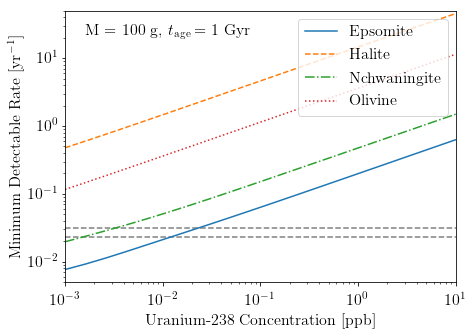

In [12]:
plt.figure(figsize=(7,5))

plt.axhline(2.3e-2, linestyle='--', color='grey')
plt.axhline(3.2e-2, linestyle='--', color='grey')

minerals = ["Epsomite","Halite","Nchwaningite", "Olivine"]
lines = ["-","--","-.",":"]
linecycler = cycle(lines)

for mine in minerals:
    plt.loglog(C238_list*1e9, R_detect_C238[mine], label=mine, linestyle=next(linecycler))

plt.xlabel(r'Uranium-238 Concentration [ppb]')
plt.ylabel(r'Minimum Detectable Rate [$\textrm{yr}^{-1}$]')
plt.legend(loc=1)

plt.text(0.05, 0.95, "M = 100 g, $t_\mathrm{age} = 1$ Gyr", 
            va='top',ha='left', transform=plt.gca().transAxes)

#------------

plt.xlim(1e-3,1e1)
plt.ylim(5e-3, 50)
plt.gca().tick_params(axis='x', which='major', pad=8)

# plt.savefig('../plots/R_min_vs_C238_minerals.pdf', bbox_inches='tight')
plt.show()